In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-20, 20))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(4521, 5) (3034, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 647ms/step - loss: 43231.0195
Epoch 2/3500
1/1 [==============================] - 0s 6ms/step - loss: 42968.0078
Epoch 3/3500
1/1 [==============================] - 0s 4ms/step - loss: 42773.7500
Epoch 4/3500
1/1 [==============================] - 0s 4ms/step - loss: 42607.3516
Epoch 5/3500
1/1 [==============================] - 0s 3ms/step - loss: 42457.2148
Epoch 6/3500
1/1 [==============================] - 0s 5ms/step - loss: 42318.2969
Epoch 7/3500
1/1 [==============================] - 0s 3ms/step - loss: 42187.6406
Epoch 8/3500
1/1 [==============================] - 0s 3ms/step - loss: 42063.1250
Epoch 9/3500
1/1 [==============================] - 0s 4ms/step - loss: 41943.0625
Epoch 10/3500
1/1 [==============================] - 0s 8ms/step - loss: 41826.0859
Epoch 11/3500
1/1 [==============================] - 0s 4ms/step - loss: 41711.1328
Epoch 12/3500
1/1 [==============================] - 0s 6ms/step - loss: 41597.5234

1/1 [==============================] - 0s 3ms/step - loss: 35541.4180
Epoch 99/3500
1/1 [==============================] - 0s 3ms/step - loss: 35499.1484
Epoch 100/3500
1/1 [==============================] - 0s 3ms/step - loss: 35457.2578
Epoch 101/3500
1/1 [==============================] - 0s 3ms/step - loss: 35415.7539
Epoch 102/3500
1/1 [==============================] - 0s 3ms/step - loss: 35374.6250
Epoch 103/3500
1/1 [==============================] - 0s 3ms/step - loss: 35333.8750
Epoch 104/3500
1/1 [==============================] - 0s 3ms/step - loss: 35293.4844
Epoch 105/3500
1/1 [==============================] - 0s 3ms/step - loss: 35253.4609
Epoch 106/3500
1/1 [==============================] - 0s 3ms/step - loss: 35213.7969
Epoch 107/3500
1/1 [==============================] - 0s 3ms/step - loss: 35174.4805
Epoch 108/3500
1/1 [==============================] - 0s 3ms/step - loss: 35135.5117
Epoch 109/3500
1/1 [==============================] - 0s 3ms/step - loss: 35096.8

1/1 [==============================] - 0s 3ms/step - loss: 32700.0605
Epoch 195/3500
1/1 [==============================] - 0s 3ms/step - loss: 32679.1035
Epoch 196/3500
1/1 [==============================] - 0s 3ms/step - loss: 32658.2578
Epoch 197/3500
1/1 [==============================] - 0s 2ms/step - loss: 32637.5293
Epoch 198/3500
1/1 [==============================] - 0s 3ms/step - loss: 32616.9082
Epoch 199/3500
1/1 [==============================] - 0s 3ms/step - loss: 32596.3984
Epoch 200/3500
1/1 [==============================] - 0s 3ms/step - loss: 32576.0000
Epoch 201/3500
1/1 [==============================] - 0s 2ms/step - loss: 32555.7109
Epoch 202/3500
1/1 [==============================] - 0s 3ms/step - loss: 32535.5234
Epoch 203/3500
1/1 [==============================] - 0s 2ms/step - loss: 32515.4473
Epoch 204/3500
1/1 [==============================] - 0s 3ms/step - loss: 32495.4688
Epoch 205/3500
1/1 [==============================] - 0s 3ms/step - loss: 32475.

1/1 [==============================] - 0s 3ms/step - loss: 31064.4082
Epoch 291/3500
1/1 [==============================] - 0s 3ms/step - loss: 31050.2109
Epoch 292/3500
1/1 [==============================] - 0s 3ms/step - loss: 31036.0469
Epoch 293/3500
1/1 [==============================] - 0s 3ms/step - loss: 31021.9258
Epoch 294/3500
1/1 [==============================] - 0s 3ms/step - loss: 31007.8438
Epoch 295/3500
1/1 [==============================] - 0s 3ms/step - loss: 30993.8047
Epoch 296/3500
1/1 [==============================] - 0s 3ms/step - loss: 30979.8008
Epoch 297/3500
1/1 [==============================] - 0s 3ms/step - loss: 30965.8359
Epoch 298/3500
1/1 [==============================] - 0s 3ms/step - loss: 30951.9102
Epoch 299/3500
1/1 [==============================] - 0s 3ms/step - loss: 30938.0234
Epoch 300/3500
1/1 [==============================] - 0s 3ms/step - loss: 30924.1699
Epoch 301/3500
1/1 [==============================] - 0s 3ms/step - loss: 30910.

1/1 [==============================] - 0s 3ms/step - loss: 29844.4316
Epoch 387/3500
1/1 [==============================] - 0s 3ms/step - loss: 29832.9043
Epoch 388/3500
1/1 [==============================] - 0s 3ms/step - loss: 29821.3984
Epoch 389/3500
1/1 [==============================] - 0s 3ms/step - loss: 29809.9102
Epoch 390/3500
1/1 [==============================] - 0s 3ms/step - loss: 29798.4453
Epoch 391/3500
1/1 [==============================] - 0s 3ms/step - loss: 29786.9961
Epoch 392/3500
1/1 [==============================] - 0s 3ms/step - loss: 29775.5684
Epoch 393/3500
1/1 [==============================] - 0s 4ms/step - loss: 29764.1543
Epoch 394/3500
1/1 [==============================] - 0s 3ms/step - loss: 29752.7656
Epoch 395/3500
1/1 [==============================] - 0s 3ms/step - loss: 29741.3887
Epoch 396/3500
1/1 [==============================] - 0s 3ms/step - loss: 29730.0312
Epoch 397/3500
1/1 [==============================] - 0s 3ms/step - loss: 29718.

1/1 [==============================] - 0s 3ms/step - loss: 28812.7930
Epoch 483/3500
1/1 [==============================] - 0s 3ms/step - loss: 28802.7383
Epoch 484/3500
1/1 [==============================] - 0s 3ms/step - loss: 28792.6992
Epoch 485/3500
1/1 [==============================] - 0s 3ms/step - loss: 28782.6719
Epoch 486/3500
1/1 [==============================] - 0s 3ms/step - loss: 28772.6543
Epoch 487/3500
1/1 [==============================] - 0s 3ms/step - loss: 28762.6504
Epoch 488/3500
1/1 [==============================] - 0s 3ms/step - loss: 28752.6621
Epoch 489/3500
1/1 [==============================] - 0s 2ms/step - loss: 28742.6836
Epoch 490/3500
1/1 [==============================] - 0s 3ms/step - loss: 28732.7188
Epoch 491/3500
1/1 [==============================] - 0s 2ms/step - loss: 28722.7695
Epoch 492/3500
1/1 [==============================] - 0s 2ms/step - loss: 28712.8281
Epoch 493/3500
1/1 [==============================] - 0s 3ms/step - loss: 28702.

1/1 [==============================] - 0s 4ms/step - loss: 27902.2773
Epoch 579/3500
1/1 [==============================] - 0s 5ms/step - loss: 27893.3477
Epoch 580/3500
1/1 [==============================] - 0s 4ms/step - loss: 27884.4297
Epoch 581/3500
1/1 [==============================] - 0s 4ms/step - loss: 27875.5195
Epoch 582/3500
1/1 [==============================] - 0s 4ms/step - loss: 27866.6211
Epoch 583/3500
1/1 [==============================] - 0s 5ms/step - loss: 27857.7363
Epoch 584/3500
1/1 [==============================] - 0s 4ms/step - loss: 27848.8594
Epoch 585/3500
1/1 [==============================] - 0s 4ms/step - loss: 27839.9980
Epoch 586/3500
1/1 [==============================] - 0s 4ms/step - loss: 27831.1426
Epoch 587/3500
1/1 [==============================] - 0s 4ms/step - loss: 27822.3008
Epoch 588/3500
1/1 [==============================] - 0s 4ms/step - loss: 27813.4688
Epoch 589/3500
1/1 [==============================] - 0s 5ms/step - loss: 27804.

1/1 [==============================] - 0s 3ms/step - loss: 27091.2188
Epoch 675/3500
1/1 [==============================] - 0s 3ms/step - loss: 27083.2188
Epoch 676/3500
1/1 [==============================] - 0s 3ms/step - loss: 27075.2266
Epoch 677/3500
1/1 [==============================] - 0s 3ms/step - loss: 27067.2461
Epoch 678/3500
1/1 [==============================] - 0s 3ms/step - loss: 27059.2695
Epoch 679/3500
1/1 [==============================] - 0s 3ms/step - loss: 27051.3008
Epoch 680/3500
1/1 [==============================] - 0s 3ms/step - loss: 27043.3438
Epoch 681/3500
1/1 [==============================] - 0s 3ms/step - loss: 27035.3906
Epoch 682/3500
1/1 [==============================] - 0s 3ms/step - loss: 27027.4512
Epoch 683/3500
1/1 [==============================] - 0s 3ms/step - loss: 27019.5137
Epoch 684/3500
1/1 [==============================] - 0s 3ms/step - loss: 27011.5898
Epoch 685/3500
1/1 [==============================] - 0s 3ms/step - loss: 27003.

1/1 [==============================] - 0s 3ms/step - loss: 26357.1348
Epoch 771/3500
1/1 [==============================] - 0s 3ms/step - loss: 26349.7852
Epoch 772/3500
1/1 [==============================] - 0s 3ms/step - loss: 26342.4414
Epoch 773/3500
1/1 [==============================] - 0s 3ms/step - loss: 26335.1016
Epoch 774/3500
1/1 [==============================] - 0s 3ms/step - loss: 26327.7617
Epoch 775/3500
1/1 [==============================] - 0s 3ms/step - loss: 26320.4277
Epoch 776/3500
1/1 [==============================] - 0s 3ms/step - loss: 26313.0938
Epoch 777/3500
1/1 [==============================] - 0s 3ms/step - loss: 26305.7637
Epoch 778/3500
1/1 [==============================] - 0s 3ms/step - loss: 26298.4336
Epoch 779/3500
1/1 [==============================] - 0s 3ms/step - loss: 26291.1055
Epoch 780/3500
1/1 [==============================] - 0s 3ms/step - loss: 26283.7773
Epoch 781/3500
1/1 [==============================] - 0s 3ms/step - loss: 26276.

1/1 [==============================] - 0s 3ms/step - loss: 25582.0273
Epoch 867/3500
1/1 [==============================] - 0s 3ms/step - loss: 25574.7031
Epoch 868/3500
1/1 [==============================] - 0s 3ms/step - loss: 25567.6172
Epoch 869/3500
1/1 [==============================] - 0s 3ms/step - loss: 25560.3125
Epoch 870/3500
1/1 [==============================] - 0s 3ms/step - loss: 25553.2461
Epoch 871/3500
1/1 [==============================] - 0s 3ms/step - loss: 25545.9531
Epoch 872/3500
1/1 [==============================] - 0s 3ms/step - loss: 25538.8945
Epoch 873/3500
1/1 [==============================] - 0s 3ms/step - loss: 25531.6133
Epoch 874/3500
1/1 [==============================] - 0s 3ms/step - loss: 25524.5664
Epoch 875/3500
1/1 [==============================] - 0s 3ms/step - loss: 25517.2930
Epoch 876/3500
1/1 [==============================] - 0s 3ms/step - loss: 25510.2578
Epoch 877/3500
1/1 [==============================] - 0s 4ms/step - loss: 25502.

1/1 [==============================] - 0s 3ms/step - loss: 24890.7344
Epoch 963/3500
1/1 [==============================] - 0s 4ms/step - loss: 24882.8301
Epoch 964/3500
1/1 [==============================] - 0s 3ms/step - loss: 24874.8750
Epoch 965/3500
1/1 [==============================] - 0s 3ms/step - loss: 24865.9375
Epoch 966/3500
1/1 [==============================] - 0s 3ms/step - loss: 24856.8867
Epoch 967/3500
1/1 [==============================] - 0s 4ms/step - loss: 24846.6836
Epoch 968/3500
1/1 [==============================] - 0s 3ms/step - loss: 24838.6328
Epoch 969/3500
1/1 [==============================] - 0s 3ms/step - loss: 24831.1367
Epoch 970/3500
1/1 [==============================] - 0s 3ms/step - loss: 24823.3828
Epoch 971/3500
1/1 [==============================] - 0s 3ms/step - loss: 24814.1055
Epoch 972/3500
1/1 [==============================] - 0s 3ms/step - loss: 24805.5156
Epoch 973/3500
1/1 [==============================] - 0s 3ms/step - loss: 24796.

1/1 [==============================] - 0s 3ms/step - loss: 24091.7383
Epoch 1058/3500
1/1 [==============================] - 0s 4ms/step - loss: 24082.8008
Epoch 1059/3500
1/1 [==============================] - 0s 3ms/step - loss: 24076.8750
Epoch 1060/3500
1/1 [==============================] - 0s 3ms/step - loss: 24067.8555
Epoch 1061/3500
1/1 [==============================] - 0s 3ms/step - loss: 24062.0566
Epoch 1062/3500
1/1 [==============================] - 0s 3ms/step - loss: 24052.9570
Epoch 1063/3500
1/1 [==============================] - 0s 3ms/step - loss: 24047.2852
Epoch 1064/3500
1/1 [==============================] - 0s 3ms/step - loss: 24038.0859
Epoch 1065/3500
1/1 [==============================] - 0s 3ms/step - loss: 24032.5430
Epoch 1066/3500
1/1 [==============================] - 0s 3ms/step - loss: 24023.2344
Epoch 1067/3500
1/1 [==============================] - 0s 3ms/step - loss: 24017.8086
Epoch 1068/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 23407.7383
Epoch 1153/3500
1/1 [==============================] - 0s 6ms/step - loss: 23410.3594
Epoch 1154/3500
1/1 [==============================] - 0s 6ms/step - loss: 23394.0469
Epoch 1155/3500
1/1 [==============================] - 0s 5ms/step - loss: 23396.9297
Epoch 1156/3500
1/1 [==============================] - 0s 6ms/step - loss: 23380.3398
Epoch 1157/3500
1/1 [==============================] - 0s 6ms/step - loss: 23383.3184
Epoch 1158/3500
1/1 [==============================] - 0s 7ms/step - loss: 23366.7461
Epoch 1159/3500
1/1 [==============================] - 0s 5ms/step - loss: 23370.1016
Epoch 1160/3500
1/1 [==============================] - 0s 7ms/step - loss: 23353.0352
Epoch 1161/3500
1/1 [==============================] - 0s 6ms/step - loss: 23356.2734
Epoch 1162/3500
1/1 [==============================] - 0s 6ms/step - loss: 23339.6250
Epoch 1163/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 22774.0195
Epoch 1248/3500
1/1 [==============================] - 0s 5ms/step - loss: 22766.6719
Epoch 1249/3500
1/1 [==============================] - 0s 5ms/step - loss: 22759.8340
Epoch 1250/3500
1/1 [==============================] - 0s 4ms/step - loss: 22753.3203
Epoch 1251/3500
1/1 [==============================] - 0s 5ms/step - loss: 22749.3809
Epoch 1252/3500
1/1 [==============================] - 0s 4ms/step - loss: 22769.2129
Epoch 1253/3500
1/1 [==============================] - 0s 4ms/step - loss: 22818.2383
Epoch 1254/3500
1/1 [==============================] - 0s 5ms/step - loss: 22751.6172
Epoch 1255/3500
1/1 [==============================] - 0s 5ms/step - loss: 22724.2578
Epoch 1256/3500
1/1 [==============================] - 0s 5ms/step - loss: 22726.2559
Epoch 1257/3500
1/1 [==============================] - 0s 4ms/step - loss: 22733.6934
Epoch 1258/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 22189.4492
Epoch 1343/3500
1/1 [==============================] - 0s 4ms/step - loss: 22148.1191
Epoch 1344/3500
1/1 [==============================] - 0s 4ms/step - loss: 22142.2422
Epoch 1345/3500
1/1 [==============================] - 0s 4ms/step - loss: 22142.0215
Epoch 1346/3500
1/1 [==============================] - 0s 3ms/step - loss: 22158.2520
Epoch 1347/3500
1/1 [==============================] - 0s 4ms/step - loss: 22146.1094
Epoch 1348/3500
1/1 [==============================] - 0s 4ms/step - loss: 22174.0488
Epoch 1349/3500
1/1 [==============================] - 0s 4ms/step - loss: 22121.5762
Epoch 1350/3500
1/1 [==============================] - 0s 4ms/step - loss: 22112.7461
Epoch 1351/3500
1/1 [==============================] - 0s 3ms/step - loss: 22127.3984
Epoch 1352/3500
1/1 [==============================] - 0s 3ms/step - loss: 22159.0859
Epoch 1353/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 21718.3906
Epoch 1438/3500
1/1 [==============================] - 0s 3ms/step - loss: 21727.6797
Epoch 1439/3500
1/1 [==============================] - 0s 3ms/step - loss: 21720.9551
Epoch 1440/3500
1/1 [==============================] - 0s 3ms/step - loss: 21741.6094
Epoch 1441/3500
1/1 [==============================] - 0s 3ms/step - loss: 21708.9316
Epoch 1442/3500
1/1 [==============================] - 0s 3ms/step - loss: 21713.6641
Epoch 1443/3500
1/1 [==============================] - 0s 3ms/step - loss: 21717.9238
Epoch 1444/3500
1/1 [==============================] - 0s 3ms/step - loss: 21744.9980
Epoch 1445/3500
1/1 [==============================] - 0s 3ms/step - loss: 21694.8047
Epoch 1446/3500
1/1 [==============================] - 0s 3ms/step - loss: 21680.2266
Epoch 1447/3500
1/1 [==============================] - 0s 3ms/step - loss: 21674.5508
Epoch 1448/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 21425.1680
Epoch 1533/3500
1/1 [==============================] - 0s 2ms/step - loss: 21399.4492
Epoch 1534/3500
1/1 [==============================] - 0s 3ms/step - loss: 21394.0742
Epoch 1535/3500
1/1 [==============================] - 0s 3ms/step - loss: 21396.7617
Epoch 1536/3500
1/1 [==============================] - 0s 2ms/step - loss: 21419.3438
Epoch 1537/3500
1/1 [==============================] - 0s 3ms/step - loss: 21402.6055
Epoch 1538/3500
1/1 [==============================] - 0s 3ms/step - loss: 21436.8184
Epoch 1539/3500
1/1 [==============================] - 0s 3ms/step - loss: 21403.8379
Epoch 1540/3500
1/1 [==============================] - 0s 3ms/step - loss: 21420.0195
Epoch 1541/3500
1/1 [==============================] - 0s 3ms/step - loss: 21394.2812
Epoch 1542/3500
1/1 [==============================] - 0s 3ms/step - loss: 21416.9043
Epoch 1543/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 20976.9980
Epoch 1628/3500
1/1 [==============================] - 0s 4ms/step - loss: 20914.1562
Epoch 1629/3500
1/1 [==============================] - 0s 5ms/step - loss: 20896.9277
Epoch 1630/3500
1/1 [==============================] - 0s 3ms/step - loss: 20892.9102
Epoch 1631/3500
1/1 [==============================] - 0s 4ms/step - loss: 20900.4883
Epoch 1632/3500
1/1 [==============================] - 0s 4ms/step - loss: 20953.2227
Epoch 1633/3500
1/1 [==============================] - 0s 5ms/step - loss: 20945.6562
Epoch 1634/3500
1/1 [==============================] - 0s 4ms/step - loss: 21050.2871
Epoch 1635/3500
1/1 [==============================] - 0s 4ms/step - loss: 20923.7930
Epoch 1636/3500
1/1 [==============================] - 0s 4ms/step - loss: 20889.9688
Epoch 1637/3500
1/1 [==============================] - 0s 4ms/step - loss: 20875.5898
Epoch 1638/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 20713.4688
Epoch 1723/3500
1/1 [==============================] - 0s 4ms/step - loss: 20666.6328
Epoch 1724/3500
1/1 [==============================] - 0s 4ms/step - loss: 20655.9766
Epoch 1725/3500
1/1 [==============================] - 0s 4ms/step - loss: 20653.5723
Epoch 1726/3500
1/1 [==============================] - 0s 4ms/step - loss: 20671.1875
Epoch 1727/3500
1/1 [==============================] - 0s 4ms/step - loss: 20771.3789
Epoch 1728/3500
1/1 [==============================] - 0s 4ms/step - loss: 20906.6250
Epoch 1729/3500
1/1 [==============================] - 0s 4ms/step - loss: 20741.8398
Epoch 1730/3500
1/1 [==============================] - 0s 4ms/step - loss: 20668.2773
Epoch 1731/3500
1/1 [==============================] - 0s 3ms/step - loss: 20641.0332
Epoch 1732/3500
1/1 [==============================] - 0s 4ms/step - loss: 20634.6016
Epoch 1733/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 20464.6582
Epoch 1818/3500
1/1 [==============================] - 0s 3ms/step - loss: 20480.7520
Epoch 1819/3500
1/1 [==============================] - 0s 3ms/step - loss: 20547.9062
Epoch 1820/3500
1/1 [==============================] - 0s 3ms/step - loss: 20514.7031
Epoch 1821/3500
1/1 [==============================] - 0s 3ms/step - loss: 20636.7070
Epoch 1822/3500
1/1 [==============================] - 0s 3ms/step - loss: 20538.1289
Epoch 1823/3500
1/1 [==============================] - 0s 3ms/step - loss: 20599.3730
Epoch 1824/3500
1/1 [==============================] - 0s 3ms/step - loss: 20498.3633
Epoch 1825/3500
1/1 [==============================] - 0s 3ms/step - loss: 20543.3516
Epoch 1826/3500
1/1 [==============================] - 0s 3ms/step - loss: 20485.4082
Epoch 1827/3500
1/1 [==============================] - 0s 3ms/step - loss: 20535.5020
Epoch 1828/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 20294.1484
Epoch 1913/3500
1/1 [==============================] - 0s 3ms/step - loss: 20305.8320
Epoch 1914/3500
1/1 [==============================] - 0s 3ms/step - loss: 20361.2461
Epoch 1915/3500
1/1 [==============================] - 0s 3ms/step - loss: 20356.4336
Epoch 1916/3500
1/1 [==============================] - 0s 3ms/step - loss: 20520.4844
Epoch 1917/3500
1/1 [==============================] - 0s 3ms/step - loss: 20395.1445
Epoch 1918/3500
1/1 [==============================] - 0s 3ms/step - loss: 20391.7930
Epoch 1919/3500
1/1 [==============================] - 0s 3ms/step - loss: 20393.9570
Epoch 1920/3500
1/1 [==============================] - 0s 3ms/step - loss: 20468.7461
Epoch 1921/3500
1/1 [==============================] - 0s 3ms/step - loss: 20320.7656
Epoch 1922/3500
1/1 [==============================] - 0s 3ms/step - loss: 20291.3965
Epoch 1923/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 20157.8340
Epoch 2008/3500
1/1 [==============================] - 0s 5ms/step - loss: 20159.6211
Epoch 2009/3500
1/1 [==============================] - 0s 4ms/step - loss: 20206.0078
Epoch 2010/3500
1/1 [==============================] - 0s 4ms/step - loss: 20221.4883
Epoch 2011/3500
1/1 [==============================] - 0s 5ms/step - loss: 20330.0234
Epoch 2012/3500
1/1 [==============================] - 0s 4ms/step - loss: 20187.4668
Epoch 2013/3500
1/1 [==============================] - 0s 4ms/step - loss: 20174.5195
Epoch 2014/3500
1/1 [==============================] - 0s 4ms/step - loss: 20169.6328
Epoch 2015/3500
1/1 [==============================] - 0s 4ms/step - loss: 20236.6191
Epoch 2016/3500
1/1 [==============================] - 0s 4ms/step - loss: 20207.0078
Epoch 2017/3500
1/1 [==============================] - 0s 4ms/step - loss: 20306.1758
Epoch 2018/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 20079.8945
Epoch 2103/3500
1/1 [==============================] - 0s 3ms/step - loss: 20172.0547
Epoch 2104/3500
1/1 [==============================] - 0s 3ms/step - loss: 20065.5605
Epoch 2105/3500
1/1 [==============================] - 0s 3ms/step - loss: 20121.2969
Epoch 2106/3500
1/1 [==============================] - 0s 3ms/step - loss: 20085.6113
Epoch 2107/3500
1/1 [==============================] - 0s 3ms/step - loss: 20167.6602
Epoch 2108/3500
1/1 [==============================] - 0s 3ms/step - loss: 20036.2148
Epoch 2109/3500
1/1 [==============================] - 0s 3ms/step - loss: 20042.2188
Epoch 2110/3500
1/1 [==============================] - 0s 3ms/step - loss: 20062.6152
Epoch 2111/3500
1/1 [==============================] - 0s 4ms/step - loss: 20149.5762
Epoch 2112/3500
1/1 [==============================] - 0s 3ms/step - loss: 20037.7402
Epoch 2113/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19959.6562
Epoch 2198/3500
1/1 [==============================] - 0s 3ms/step - loss: 19979.1914
Epoch 2199/3500
1/1 [==============================] - 0s 3ms/step - loss: 20100.6953
Epoch 2200/3500
1/1 [==============================] - 0s 4ms/step - loss: 19941.2324
Epoch 2201/3500
1/1 [==============================] - 0s 5ms/step - loss: 19929.4961
Epoch 2202/3500
1/1 [==============================] - 0s 8ms/step - loss: 19938.7500
Epoch 2203/3500
1/1 [==============================] - 0s 4ms/step - loss: 20023.4688
Epoch 2204/3500
1/1 [==============================] - 0s 4ms/step - loss: 19931.2539
Epoch 2205/3500
1/1 [==============================] - 0s 4ms/step - loss: 19982.2852
Epoch 2206/3500
1/1 [==============================] - 0s 4ms/step - loss: 19979.0312
Epoch 2207/3500
1/1 [==============================] - 0s 4ms/step - loss: 20079.5117
Epoch 2208/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 19876.2188
Epoch 2293/3500
1/1 [==============================] - 0s 4ms/step - loss: 19988.6074
Epoch 2294/3500
1/1 [==============================] - 0s 5ms/step - loss: 19821.1113
Epoch 2295/3500
1/1 [==============================] - 0s 5ms/step - loss: 19798.0312
Epoch 2296/3500
1/1 [==============================] - 0s 5ms/step - loss: 19799.4141
Epoch 2297/3500
1/1 [==============================] - 0s 8ms/step - loss: 19858.2402
Epoch 2298/3500
1/1 [==============================] - 0s 6ms/step - loss: 19859.2734
Epoch 2299/3500
1/1 [==============================] - 0s 4ms/step - loss: 19984.7676
Epoch 2300/3500
1/1 [==============================] - 0s 4ms/step - loss: 19825.6523
Epoch 2301/3500
1/1 [==============================] - 0s 4ms/step - loss: 19818.8750
Epoch 2302/3500
1/1 [==============================] - 0s 4ms/step - loss: 19838.7266
Epoch 2303/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19785.9668
Epoch 2388/3500
1/1 [==============================] - 0s 4ms/step - loss: 19746.1953
Epoch 2389/3500
1/1 [==============================] - 0s 3ms/step - loss: 19849.9902
Epoch 2390/3500
1/1 [==============================] - 0s 4ms/step - loss: 19743.5566
Epoch 2391/3500
1/1 [==============================] - 0s 3ms/step - loss: 19796.3047
Epoch 2392/3500
1/1 [==============================] - 0s 4ms/step - loss: 19757.7031
Epoch 2393/3500
1/1 [==============================] - 0s 5ms/step - loss: 19853.8770
Epoch 2394/3500
1/1 [==============================] - 0s 4ms/step - loss: 19703.8320
Epoch 2395/3500
1/1 [==============================] - 0s 4ms/step - loss: 19692.4102
Epoch 2396/3500
1/1 [==============================] - 0s 3ms/step - loss: 19710.3750
Epoch 2397/3500
1/1 [==============================] - 0s 5ms/step - loss: 19802.9590
Epoch 2398/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19620.2559
Epoch 2483/3500
1/1 [==============================] - 0s 5ms/step - loss: 19627.2266
Epoch 2484/3500
1/1 [==============================] - 0s 5ms/step - loss: 19652.2930
Epoch 2485/3500
1/1 [==============================] - 0s 4ms/step - loss: 19771.7051
Epoch 2486/3500
1/1 [==============================] - 0s 5ms/step - loss: 19625.0957
Epoch 2487/3500
1/1 [==============================] - 0s 5ms/step - loss: 19611.9980
Epoch 2488/3500
1/1 [==============================] - 0s 4ms/step - loss: 19637.2129
Epoch 2489/3500
1/1 [==============================] - 0s 5ms/step - loss: 19751.3164
Epoch 2490/3500
1/1 [==============================] - 0s 4ms/step - loss: 19620.2852
Epoch 2491/3500
1/1 [==============================] - 0s 4ms/step - loss: 19621.5098
Epoch 2492/3500
1/1 [==============================] - 0s 6ms/step - loss: 19649.7969
Epoch 2493/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19663.2852
Epoch 2578/3500
1/1 [==============================] - 0s 3ms/step - loss: 19535.7109
Epoch 2579/3500
1/1 [==============================] - 0s 3ms/step - loss: 19535.7383
Epoch 2580/3500
1/1 [==============================] - 0s 3ms/step - loss: 19555.5547
Epoch 2581/3500
1/1 [==============================] - 0s 3ms/step - loss: 19668.3613
Epoch 2582/3500
1/1 [==============================] - 0s 3ms/step - loss: 19532.1211
Epoch 2583/3500
1/1 [==============================] - 0s 3ms/step - loss: 19525.6953
Epoch 2584/3500
1/1 [==============================] - 0s 3ms/step - loss: 19546.0156
Epoch 2585/3500
1/1 [==============================] - 0s 4ms/step - loss: 19655.9258
Epoch 2586/3500
1/1 [==============================] - 0s 3ms/step - loss: 19528.2891
Epoch 2587/3500
1/1 [==============================] - 0s 3ms/step - loss: 19528.1016
Epoch 2588/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19464.4512
Epoch 2673/3500
1/1 [==============================] - 0s 3ms/step - loss: 19565.2617
Epoch 2674/3500
1/1 [==============================] - 0s 3ms/step - loss: 19448.0020
Epoch 2675/3500
1/1 [==============================] - 0s 3ms/step - loss: 19449.0410
Epoch 2676/3500
1/1 [==============================] - 0s 3ms/step - loss: 19459.1758
Epoch 2677/3500
1/1 [==============================] - 0s 3ms/step - loss: 19558.6094
Epoch 2678/3500
1/1 [==============================] - 0s 3ms/step - loss: 19443.7383
Epoch 2679/3500
1/1 [==============================] - 0s 3ms/step - loss: 19445.3613
Epoch 2680/3500
1/1 [==============================] - 0s 3ms/step - loss: 19455.9395
Epoch 2681/3500
1/1 [==============================] - 0s 3ms/step - loss: 19555.6309
Epoch 2682/3500
1/1 [==============================] - 0s 3ms/step - loss: 19440.8750
Epoch 2683/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19372.3301
Epoch 2768/3500
1/1 [==============================] - 0s 3ms/step - loss: 19376.4395
Epoch 2769/3500
1/1 [==============================] - 0s 3ms/step - loss: 19461.3789
Epoch 2770/3500
1/1 [==============================] - 0s 3ms/step - loss: 19363.7734
Epoch 2771/3500
1/1 [==============================] - 0s 3ms/step - loss: 19360.9805
Epoch 2772/3500
1/1 [==============================] - 0s 3ms/step - loss: 19365.8750
Epoch 2773/3500
1/1 [==============================] - 0s 3ms/step - loss: 19448.4492
Epoch 2774/3500
1/1 [==============================] - 0s 4ms/step - loss: 19360.1172
Epoch 2775/3500
1/1 [==============================] - 0s 4ms/step - loss: 19364.3320
Epoch 2776/3500
1/1 [==============================] - 0s 3ms/step - loss: 19368.1289
Epoch 2777/3500
1/1 [==============================] - 0s 4ms/step - loss: 19450.9805
Epoch 2778/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19312.7812
Epoch 2863/3500
1/1 [==============================] - 0s 3ms/step - loss: 19387.5898
Epoch 2864/3500
1/1 [==============================] - 0s 3ms/step - loss: 19305.9980
Epoch 2865/3500
1/1 [==============================] - 0s 3ms/step - loss: 19302.2578
Epoch 2866/3500
1/1 [==============================] - 0s 3ms/step - loss: 19304.7422
Epoch 2867/3500
1/1 [==============================] - 0s 3ms/step - loss: 19375.4062
Epoch 2868/3500
1/1 [==============================] - 0s 3ms/step - loss: 19300.9766
Epoch 2869/3500
1/1 [==============================] - 0s 3ms/step - loss: 19302.3242
Epoch 2870/3500
1/1 [==============================] - 0s 3ms/step - loss: 19303.7188
Epoch 2871/3500
1/1 [==============================] - 0s 4ms/step - loss: 19372.9062
Epoch 2872/3500
1/1 [==============================] - 0s 3ms/step - loss: 19303.3965
Epoch 2873/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19277.8242
Epoch 2958/3500
1/1 [==============================] - 0s 4ms/step - loss: 19259.0840
Epoch 2959/3500
1/1 [==============================] - 0s 4ms/step - loss: 19304.2930
Epoch 2960/3500
1/1 [==============================] - 0s 4ms/step - loss: 19258.5469
Epoch 2961/3500
1/1 [==============================] - 0s 5ms/step - loss: 19280.4082
Epoch 2962/3500
1/1 [==============================] - 0s 4ms/step - loss: 19260.4609
Epoch 2963/3500
1/1 [==============================] - 0s 4ms/step - loss: 19304.5938
Epoch 2964/3500
1/1 [==============================] - 0s 4ms/step - loss: 19260.7988
Epoch 2965/3500
1/1 [==============================] - 0s 4ms/step - loss: 19286.3828
Epoch 2966/3500
1/1 [==============================] - 0s 4ms/step - loss: 19260.6367
Epoch 2967/3500
1/1 [==============================] - 0s 4ms/step - loss: 19299.3828
Epoch 2968/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19213.0254
Epoch 3053/3500
1/1 [==============================] - 0s 3ms/step - loss: 19250.7559
Epoch 3054/3500
1/1 [==============================] - 0s 3ms/step - loss: 19224.4258
Epoch 3055/3500
1/1 [==============================] - 0s 3ms/step - loss: 19260.7637
Epoch 3056/3500
1/1 [==============================] - 0s 3ms/step - loss: 19221.2344
Epoch 3057/3500
1/1 [==============================] - 0s 3ms/step - loss: 19244.8906
Epoch 3058/3500
1/1 [==============================] - 0s 3ms/step - loss: 19218.0176
Epoch 3059/3500
1/1 [==============================] - 0s 3ms/step - loss: 19250.2773
Epoch 3060/3500
1/1 [==============================] - 0s 3ms/step - loss: 19220.5547
Epoch 3061/3500
1/1 [==============================] - 0s 3ms/step - loss: 19279.7715
Epoch 3062/3500
1/1 [==============================] - 0s 3ms/step - loss: 19231.7148
Epoch 3063/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19095.3828
Epoch 3148/3500
1/1 [==============================] - 0s 3ms/step - loss: 19094.2988
Epoch 3149/3500
1/1 [==============================] - 0s 3ms/step - loss: 19098.7812
Epoch 3150/3500
1/1 [==============================] - 0s 3ms/step - loss: 19109.9805
Epoch 3151/3500
1/1 [==============================] - 0s 3ms/step - loss: 19140.6055
Epoch 3152/3500
1/1 [==============================] - 0s 3ms/step - loss: 19194.5176
Epoch 3153/3500
1/1 [==============================] - 0s 3ms/step - loss: 19316.3242
Epoch 3154/3500
1/1 [==============================] - 0s 3ms/step - loss: 19303.4961
Epoch 3155/3500
1/1 [==============================] - 0s 3ms/step - loss: 19371.1289
Epoch 3156/3500
1/1 [==============================] - 0s 3ms/step - loss: 19202.9297
Epoch 3157/3500
1/1 [==============================] - 0s 3ms/step - loss: 19158.8984
Epoch 3158/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19150.2148
Epoch 3243/3500
1/1 [==============================] - 0s 3ms/step - loss: 19177.7188
Epoch 3244/3500
1/1 [==============================] - 0s 3ms/step - loss: 19150.5273
Epoch 3245/3500
1/1 [==============================] - 0s 3ms/step - loss: 19175.1426
Epoch 3246/3500
1/1 [==============================] - 0s 2ms/step - loss: 19154.6250
Epoch 3247/3500
1/1 [==============================] - 0s 3ms/step - loss: 19191.2539
Epoch 3248/3500
1/1 [==============================] - 0s 3ms/step - loss: 19162.3535
Epoch 3249/3500
1/1 [==============================] - 0s 2ms/step - loss: 19192.5586
Epoch 3250/3500
1/1 [==============================] - 0s 3ms/step - loss: 19153.7949
Epoch 3251/3500
1/1 [==============================] - 0s 3ms/step - loss: 19174.4648
Epoch 3252/3500
1/1 [==============================] - 0s 3ms/step - loss: 19201.1465
Epoch 3253/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 19197.6367
Epoch 3338/3500
1/1 [==============================] - 0s 3ms/step - loss: 19201.6621
Epoch 3339/3500
1/1 [==============================] - 0s 3ms/step - loss: 19164.6523
Epoch 3340/3500
1/1 [==============================] - 0s 3ms/step - loss: 19122.6016
Epoch 3341/3500
1/1 [==============================] - 0s 3ms/step - loss: 19138.1582
Epoch 3342/3500
1/1 [==============================] - 0s 3ms/step - loss: 19113.4609
Epoch 3343/3500
1/1 [==============================] - 0s 3ms/step - loss: 19139.9531
Epoch 3344/3500
1/1 [==============================] - 0s 3ms/step - loss: 19123.3398
Epoch 3345/3500
1/1 [==============================] - 0s 3ms/step - loss: 19157.9629
Epoch 3346/3500
1/1 [==============================] - 0s 3ms/step - loss: 19124.5898
Epoch 3347/3500
1/1 [==============================] - 0s 3ms/step - loss: 19146.9609
Epoch 3348/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19097.9805
Epoch 3433/3500
1/1 [==============================] - 0s 3ms/step - loss: 19166.9922
Epoch 3434/3500
1/1 [==============================] - 0s 4ms/step - loss: 19097.7852
Epoch 3435/3500
1/1 [==============================] - 0s 4ms/step - loss: 19168.5234
Epoch 3436/3500
1/1 [==============================] - 0s 3ms/step - loss: 19097.1172
Epoch 3437/3500
1/1 [==============================] - 0s 3ms/step - loss: 19123.3125
Epoch 3438/3500
1/1 [==============================] - 0s 4ms/step - loss: 19108.5098
Epoch 3439/3500
1/1 [==============================] - 0s 4ms/step - loss: 19138.6934
Epoch 3440/3500
1/1 [==============================] - 0s 3ms/step - loss: 19095.2559
Epoch 3441/3500
1/1 [==============================] - 0s 3ms/step - loss: 19101.6719
Epoch 3442/3500
1/1 [==============================] - 0s 3ms/step - loss: 19089.8496
Epoch 3443/3500
1/1 [==============================] - 0s 3ms/step - l

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

95/95 [==============================] - 0s 497us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

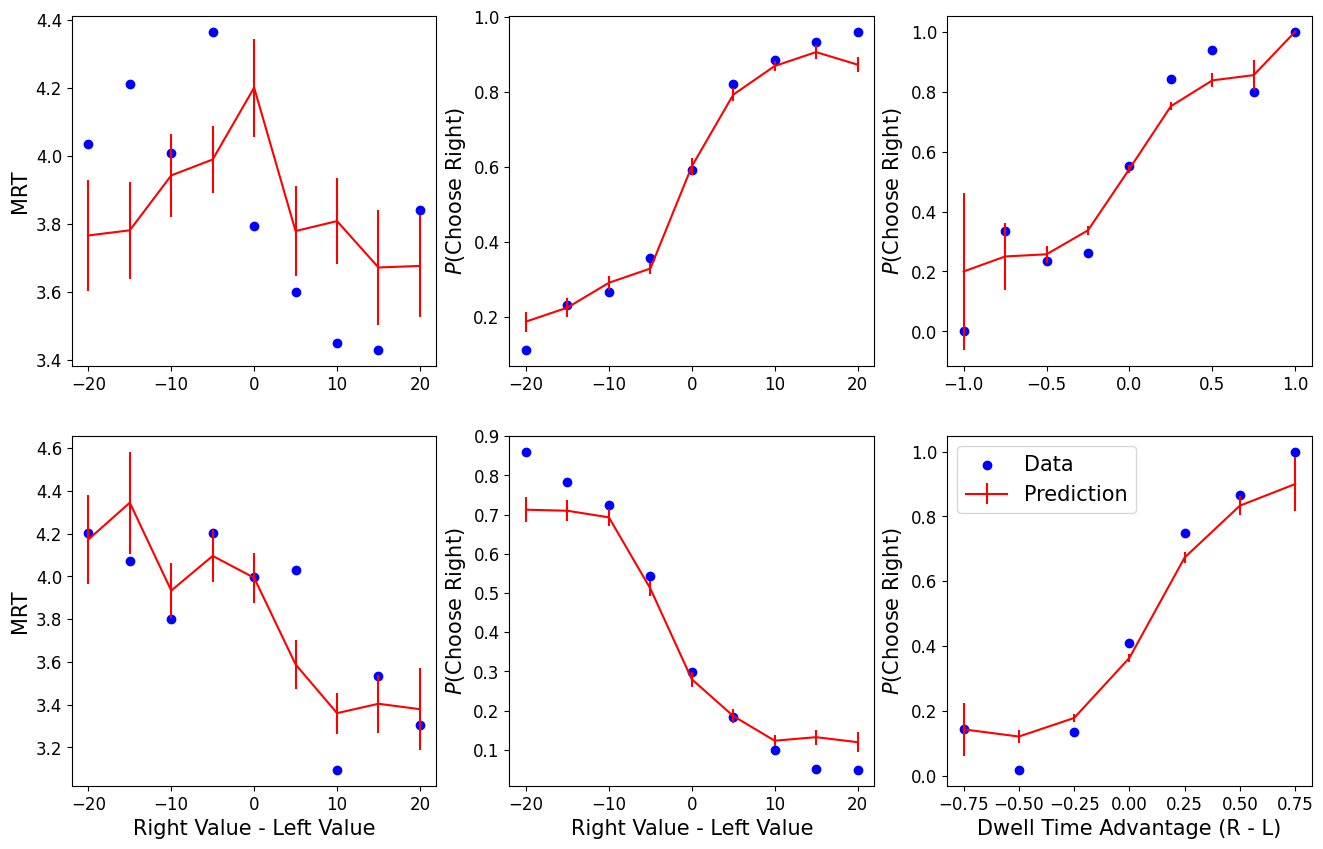

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_perceptual_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

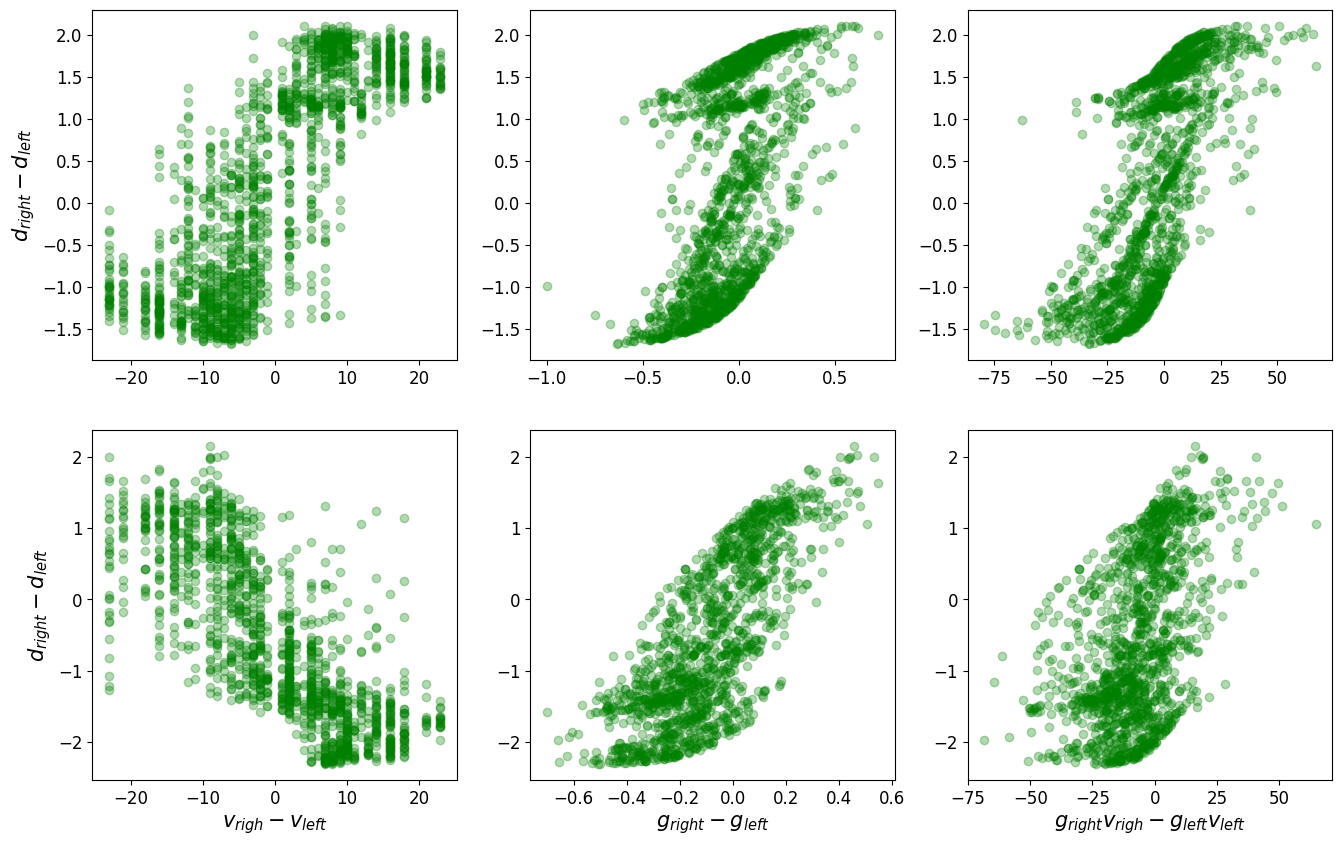

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');